This notebook implements **pneumonia detection from chest X-ray images** using transfer learning with VGG16 and ResNet50 models pre-trained on ImageNet.

### Objective
Develop a deep learning classifier for automatic pneumonia detection with high sensitivity (recall ≥95%) for clinical screening applications.

### Dataset Information
- **Source**: Chest X-Ray Images (Pneumonia)
- **Classes**: Normal (0) vs Pneumonia (1)
- **Total**: ~5,840 images
- **Split**: 80% train (4,172), 20% validation (1,044), Test (624)
- **Imbalance**: ~3:1 ratio (Pneumonia:Normal)

### Models
- **VGG16**: 16-layer CNN, Learning Rate: 1e-5
- **ResNet50**: 50-layer with residual connections, Learning Rate: 1e-4


---

## 1. Setup and Configuration

### 1.1 Import Required Libraries
Loading essential libraries for data processing, deep learning, and visualization.

In [79]:
# Import Libraries
import os
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as T
import torchvision.models as models
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, confusion_matrix, classification_report,
                            roc_curve, auc)

### 1.2 Reproducibility Setup
Setting random seeds for reproducible results across runs.

In [80]:
# Set random seeds
random.seed(42)
np.random.seed(42)
os.environ['PYTHONHASHSEED'] = '42'
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
if torch.backends.mps.is_available():
    torch.mps.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 
                     'mps' if torch.backends.mps.is_available() else 
                     'cpu')
print(f"Using device: {device}")

Using device: mps


### 1.3 Directory Structure and Constants
Defining paths for data, models, and results storage.

In [81]:
# Data Paths
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR / 'chest_xray'
TRAIN_DIR = DATA_DIR / 'train'
TEST_DIR = DATA_DIR / 'test'

# Results Directory
RESULTS_DIR = BASE_DIR / 'results_notebook_2'
RESULTS_DIR.mkdir(exist_ok=True)

# Training Constants
NUM_EPOCHS = 25
BATCH_SIZE = 32
CLASS_NAMES = ['Normal', 'Pneumonia']

print(f"Train directory exists: {TRAIN_DIR.exists()}")
print(f"Test directory exists: {TEST_DIR.exists()}")
print(f"Results will be saved to: {RESULTS_DIR}")

Train directory exists: True
Test directory exists: True
Results will be saved to: /Users/akashkinu/Developer/ChestXrayProject/results_notebook_2


---

## 2. Data Preparation

### 2.1 Custom Dataset Class
Implementing a PyTorch Dataset class for flexible chest X-ray loading.

In [82]:
# Custom Dataset Class
class ChestXRayDataset(Dataset):
    """
    Custom Dataset for Chest X-Ray images.
    
    Args:
        root_dir (str/Path): Path to directory containing NORMAL and PNEUMONIA folders
        transform (callable, optional): Optional transform to apply to images
    
    Returns:
        tuple: (image, label) where label is 0 for NORMAL, 1 for PNEUMONIA
    """
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        
        self.image_paths = []
        self.labels = []
        self.class_names = ['NORMAL', 'PNEUMONIA']
        
        # Load image paths and labels
        for class_idx, class_name in enumerate(self.class_names):
            class_dir = self.root_dir / class_name
            if class_dir.exists():
                for img_path in class_dir.glob('*.jpeg'):
                    self.image_paths.append(img_path)
                    self.labels.append(class_idx)
        
        print(f"Loaded {len(self.image_paths)} images from {self.root_dir}")
        print(f"  NORMAL: {self.labels.count(0)}")
        print(f"  PNEUMONIA: {self.labels.count(1)}")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

print("✓ ChestXRayDataset class defined")

✓ ChestXRayDataset class defined


### 2.2 Load Training Dataset
Loading the complete training dataset to analyze class distribution.

In [83]:
# Load Full Training Dataset (without transforms initially)
full_dataset = ChestXRayDataset(TRAIN_DIR, transform=None)

# Get class distribution
labels = full_dataset.labels
class_counts = Counter(labels)

print("\n📊 Class Distribution in Training Data:")
for class_idx, count in class_counts.items():
    class_name = full_dataset.class_names[class_idx]
    percentage = (count / len(labels)) * 100
    print(f"  {class_name}: {count} ({percentage:.1f}%)")

# Calculate class weights for handling imbalance
class_weights = torch.tensor([
    len(labels) / (len(class_counts) * class_counts[0]),
    len(labels) / (len(class_counts) * class_counts[1])
], dtype=torch.float32).to(device)

print(f"\n⚖️  Class Weights: {class_weights.cpu().numpy()}")

Loaded 5216 images from /Users/akashkinu/Developer/ChestXrayProject/chest_xray/train
  NORMAL: 1341
  PNEUMONIA: 3875

📊 Class Distribution in Training Data:
  NORMAL: 1341 (25.7%)
  PNEUMONIA: 3875 (74.3%)

⚖️  Class Weights: [1.9448173 0.6730323]


### 2.3 Class Distribution Visualization
Visualizing the imbalance between Normal and Pneumonia cases.

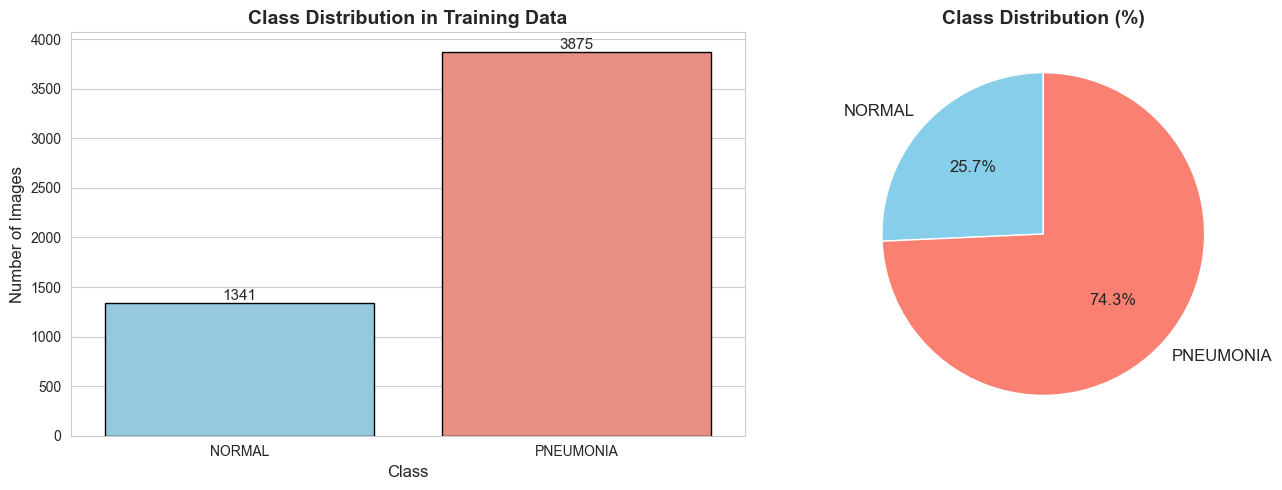

✓ Class distribution visualization saved


In [84]:
# Visualize Class Distribution
data = []
for class_idx, count in class_counts.items():
    data.append({
        'Class Type': full_dataset.class_names[class_idx], 
        'Count': count
    })
df = pd.DataFrame(data)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
sns.set_style('whitegrid')

# Bar Plot
colors = ['skyblue', 'salmon']
bars = sns.barplot(data=df, x='Class Type', y='Count', palette=colors, 
                   edgecolor='black', ax=ax1)
ax1.set_title('Class Distribution in Training Data', fontsize=14, fontweight='bold')
ax1.set_ylabel('Number of Images', fontsize=12)
ax1.set_xlabel('Class', fontsize=12)

# Add count labels on bars
for container in ax1.containers:
    ax1.bar_label(container, fmt='%d', fontsize=11)

# Pie Chart
ax2.pie(df['Count'], labels=df['Class Type'], autopct='%1.1f%%',
        colors=colors, startangle=90, textprops={'fontsize': 12})
ax2.set_title('Class Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Class distribution visualization saved")

### 2.4 Stratified Train-Validation Split
Creating an 80-20 stratified split to maintain class distribution.

**Why 20% validation?**
- Larger validation set (1,044 vs 783 in Notebook 1)
- More robust performance estimates
- Better early stopping decisions

In [85]:
# Create 80-20 Train-Validation Split (Stratified)
print("\n📂 Creating 20% validation split...")

indices = np.arange(len(full_dataset))
train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

print(f"  Training samples: {len(train_idx)}")
print(f"  Validation samples: {len(val_idx)}")

# Verify stratification
train_labels = [labels[i] for i in train_idx]
val_labels = [labels[i] for i in val_idx]

train_dist = Counter(train_labels)
val_dist = Counter(val_labels)

print(f"\n  Train distribution: Normal={train_dist[0]}, Pneumonia={train_dist[1]}")
print(f"  Val distribution: Normal={val_dist[0]}, Pneumonia={val_dist[1]}")


📂 Creating 20% validation split...
  Training samples: 4172
  Validation samples: 1044

  Train distribution: Normal=1073, Pneumonia=3099
  Val distribution: Normal=268, Pneumonia=776


### 2.5 Data Augmentation and Loaders
Defining transformations and creating DataLoaders for efficient batching.

**Training Augmentations**:
- Random horizontal flip
- Random rotation (±10°)
- Color jitter
- Normalization (ImageNet stats)

**Validation/Test**: Resize and normalize only (no augmentation)

In [86]:
# Define Data Transforms
train_transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225])
])

val_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225])
])

print("✓ Transforms defined")
print("  Train: Resize + Augmentation + Normalize")
print("  Val/Test: Resize + Normalize only")

✓ Transforms defined
  Train: Resize + Augmentation + Normalize
  Val/Test: Resize + Normalize only


In [87]:
# Create Datasets with Transforms
train_dataset = ChestXRayDataset(TRAIN_DIR, transform=train_transform)
train_subset = Subset(train_dataset, train_idx)

val_dataset = ChestXRayDataset(TRAIN_DIR, transform=val_transform)
val_subset = Subset(val_dataset, val_idx)

test_dataset = ChestXRayDataset(TEST_DIR, transform=val_transform)

print(f"\n✓ Datasets created:")
print(f"  Train subset: {len(train_subset)} images")
print(f"  Val subset: {len(val_subset)} images")
print(f"  Test: {len(test_dataset)} images")

Loaded 5216 images from /Users/akashkinu/Developer/ChestXrayProject/chest_xray/train
  NORMAL: 1341
  PNEUMONIA: 3875
Loaded 5216 images from /Users/akashkinu/Developer/ChestXrayProject/chest_xray/train
  NORMAL: 1341
  PNEUMONIA: 3875
Loaded 624 images from /Users/akashkinu/Developer/ChestXrayProject/chest_xray/test
  NORMAL: 234
  PNEUMONIA: 390

✓ Datasets created:
  Train subset: 4172 images
  Val subset: 1044 images
  Test: 624 images


In [88]:
# Create DataLoaders
print("\n📦 Creating data loaders...")

train_loader = DataLoader(
    train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,  # Set to 0 to avoid multiprocessing issues on macOS
    pin_memory=False
)

val_loader = DataLoader(
    val_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,  # Set to 0 to avoid multiprocessing issues on macOS
    pin_memory=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,  # Set to 0 to avoid multiprocessing issues on macOS
    pin_memory=False
)

print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test samples: {len(test_dataset)}")
print("\n✓ Data preparation complete!")


📦 Creating data loaders...
  Train batches: 131
  Val batches: 33
  Test samples: 624

✓ Data preparation complete!


---

## 3. Model Architecture

### 3.1 Model Definitions
Defining VGG16 and ResNet50 with modified classifiers for binary classification.

**Transfer Learning Strategy**:
1. Load pre-trained ImageNet weights
2. Freeze early layers (feature extraction)
3. Replace classifier for binary output
4. Fine-tune on chest X-rays

In [89]:
# ResNet50 Model Definition
class PneumoniaResNet(nn.Module):
    """
    ResNet50 modified for binary pneumonia classification.
    
    Features:
    - Pre-trained ResNet50 backbone
    - Frozen early layers
    - Custom classifier with dropout
    """
    def __init__(self, num_classes=2, dropout_rate=0.5):
        super(PneumoniaResNet, self).__init__()
        
        # Load pre-trained ResNet50
        self.backbone = models.resnet50(pretrained=True)
        
        # Freeze early layers (only train later layers)
        for param in list(self.backbone.parameters())[:-20]:
            param.requires_grad = False
        
        # Replace final FC layer
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

print("✓ PneumoniaResNet class defined")

✓ PneumoniaResNet class defined


In [90]:
# VGG16 Model Definition
class PneumoniaVGG16(nn.Module):
    """
    VGG16 modified for binary pneumonia classification.
    
    Features:
    - Pre-trained VGG16 backbone
    - Frozen convolutional layers
    - Custom classifier with dropout
    """
    def __init__(self, num_classes=2, dropout_rate=0.5):
        super(PneumoniaVGG16, self).__init__()
        
        # Load pre-trained VGG16
        self.features = models.vgg16(pretrained=True).features
        
        # Freeze convolutional layers
        for param in self.features.parameters():
            param.requires_grad = False
        
        # Custom classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((7, 7)),
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

print("✓ PneumoniaVGG16 class defined")

✓ PneumoniaVGG16 class defined


---

## 4. Model Training

### 4.1 ResNet50 Training
Training ResNet50 with AdamW optimizer and learning rate scheduling.

**Hyperparameters**:
- Learning Rate: 1e-4
- Optimizer: AdamW (weight decay: 1e-4)
- Loss: CrossEntropyLoss with class weights
- Scheduler: ReduceLROnPlateau
- Epochs: 25

In [91]:
# Initialize ResNet50 Model
print("\n🚀 Initializing ResNet50...")

resnet_model = PneumoniaResNet().to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, resnet_model.parameters()),
    lr=1e-4,
    weight_decay=1e-4
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

print(f"✓ ResNet50 initialized")
print(f"  Trainable parameters: {sum(p.numel() for p in resnet_model.parameters() if p.requires_grad):,}")


🚀 Initializing ResNet50...
✓ ResNet50 initialized
  Trainable parameters: 8,929,282


In [92]:
# Train ResNet50
print("\n📈 Training ResNet50...\n")

resnet_history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_val_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    # Training Phase
    resnet_model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()
    
    train_loss /= len(train_loader)
    train_acc = 100.0 * train_correct / train_total
    
    # Validation Phase
    resnet_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet_model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    
    val_loss /= len(val_loader)
    val_acc = 100.0 * val_correct / val_total
    
    # Save history
    resnet_history['train_loss'].append(train_loss)
    resnet_history['val_loss'].append(val_loss)
    resnet_history['train_acc'].append(train_acc)
    resnet_history['val_acc'].append(val_acc)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Print progress
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(resnet_model.state_dict(), RESULTS_DIR / 'resnet50_best.pth')
        print(f"  ✓ Best model saved!")

print("\n✓ ResNet50 training complete!")


📈 Training ResNet50...

Epoch 1/25
  Train Loss: 0.1732, Acc: 93.29%
  Val Loss: 0.1299, Acc: 96.65%
  ✓ Best model saved!
Epoch 2/25
  Train Loss: 0.1117, Acc: 95.69%
  Val Loss: 0.0907, Acc: 96.65%
  ✓ Best model saved!
Epoch 3/25
  Train Loss: 0.0844, Acc: 96.81%
  Val Loss: 0.1106, Acc: 97.22%
Epoch 4/25
  Train Loss: 0.0686, Acc: 97.32%
  Val Loss: 0.0753, Acc: 97.99%
  ✓ Best model saved!
Epoch 5/25
  Train Loss: 0.0650, Acc: 97.65%
  Val Loss: 0.0656, Acc: 97.99%
  ✓ Best model saved!
Epoch 6/25
  Train Loss: 0.0622, Acc: 97.44%
  Val Loss: 0.0614, Acc: 97.13%
  ✓ Best model saved!
Epoch 7/25
  Train Loss: 0.0526, Acc: 98.06%
  Val Loss: 0.0511, Acc: 98.37%
  ✓ Best model saved!
Epoch 8/25
  Train Loss: 0.0516, Acc: 98.01%
  Val Loss: 0.0474, Acc: 98.56%
  ✓ Best model saved!
Epoch 9/25
  Train Loss: 0.0396, Acc: 98.63%
  Val Loss: 0.0482, Acc: 98.28%
Epoch 10/25
  Train Loss: 0.0380, Acc: 98.42%
  Val Loss: 0.0457, Acc: 97.89%
  ✓ Best model saved!
Epoch 11/25
  Train Loss: 0.

### 4.2 VGG16 Training
Training VGG16 with lower learning rate (1e-5) for careful fine-tuning.

**Why Lower Learning Rate?**
- Prevents destroying pre-trained features
- Allows gentle adaptation to medical domain
- Better convergence for VGG architecture

In [93]:
# Initialize VGG16 Model
print("\n🚀 Initializing VGG16...")

vgg_model = PneumoniaVGG16().to(device)

# Loss and Optimizer (lower LR!)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, vgg_model.parameters()),
    lr=1e-5,  # 10x lower than ResNet50
    weight_decay=1e-4
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

print(f"✓ VGG16 initialized")
print(f"  Trainable parameters: {sum(p.numel() for p in vgg_model.parameters() if p.requires_grad):,}")


🚀 Initializing VGG16...
✓ VGG16 initialized
  Trainable parameters: 106,961,922


In [94]:
# Train VGG16
print("\n📈 Training VGG16...\n")

vgg_history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_val_loss = float('inf')
patience_counter = 0
PATIENCE = 7

for epoch in range(NUM_EPOCHS):
    # Training Phase
    vgg_model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = vgg_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()
    
    train_loss /= len(train_loader)
    train_acc = 100.0 * train_correct / train_total
    
    # Validation Phase
    vgg_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg_model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    
    val_loss /= len(val_loader)
    val_acc = 100.0 * val_correct / val_total
    
    # Save history
    vgg_history['train_loss'].append(train_loss)
    vgg_history['val_loss'].append(val_loss)
    vgg_history['train_acc'].append(train_acc)
    vgg_history['val_acc'].append(val_acc)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Print progress
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
    
    # Save best model & Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(vgg_model.state_dict(), RESULTS_DIR / 'vgg16_best.pth')
        print(f"  ✓ Best model saved!")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"\n⏹️  Early stopping at epoch {epoch+1}")
            break

print("\n✓ VGG16 training complete!")


📈 Training VGG16...

Epoch 1/25
  Train Loss: 0.2703, Acc: 90.17%
  Val Loss: 0.1244, Acc: 93.77%
  ✓ Best model saved!
Epoch 2/25
  Train Loss: 0.1214, Acc: 95.13%
  Val Loss: 0.0977, Acc: 95.02%
  ✓ Best model saved!
Epoch 3/25
  Train Loss: 0.0967, Acc: 96.33%
  Val Loss: 0.1218, Acc: 93.10%
Epoch 4/25
  Train Loss: 0.0849, Acc: 96.64%
  Val Loss: 0.0912, Acc: 95.59%
  ✓ Best model saved!
Epoch 5/25
  Train Loss: 0.0717, Acc: 97.48%
  Val Loss: 0.0665, Acc: 97.13%
  ✓ Best model saved!
Epoch 6/25
  Train Loss: 0.0670, Acc: 97.41%
  Val Loss: 0.0632, Acc: 97.32%
  ✓ Best model saved!
Epoch 7/25
  Train Loss: 0.0609, Acc: 97.84%
  Val Loss: 0.0708, Acc: 96.84%
Epoch 8/25
  Train Loss: 0.0576, Acc: 97.75%
  Val Loss: 0.0628, Acc: 97.03%
  ✓ Best model saved!
Epoch 9/25
  Train Loss: 0.0596, Acc: 97.65%
  Val Loss: 0.0604, Acc: 97.51%
  ✓ Best model saved!
Epoch 10/25
  Train Loss: 0.0552, Acc: 98.08%
  Val Loss: 0.0727, Acc: 96.84%
Epoch 11/25
  Train Loss: 0.0538, Acc: 97.84%
  Val L

### 4.3 Training History Visualization
Plotting loss and accuracy curves to monitor training progress.


📊 Plotting training curves...


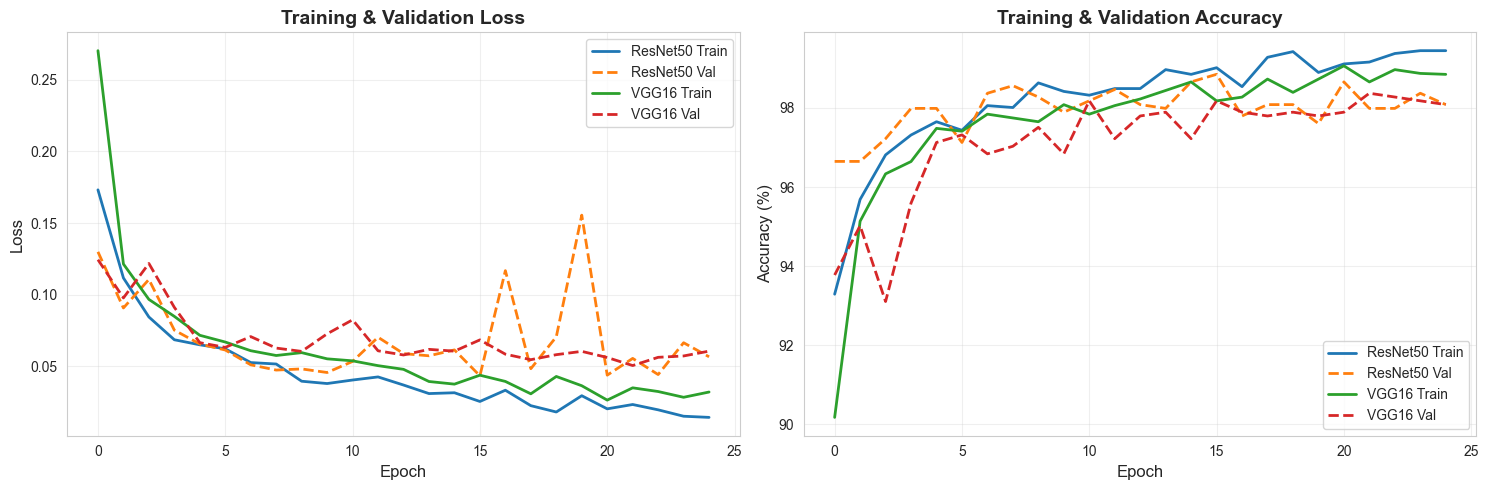

✓ Training curves saved


In [95]:
# Plot Training Curves
print("\n📊 Plotting training curves...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss Curves
ax1.plot(resnet_history['train_loss'], label='ResNet50 Train', linestyle='-', linewidth=2)
ax1.plot(resnet_history['val_loss'], label='ResNet50 Val', linestyle='--', linewidth=2)
ax1.plot(vgg_history['train_loss'], label='VGG16 Train', linestyle='-', linewidth=2)
ax1.plot(vgg_history['val_loss'], label='VGG16 Val', linestyle='--', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy Curves
ax2.plot(resnet_history['train_acc'], label='ResNet50 Train', linestyle='-', linewidth=2)
ax2.plot(resnet_history['val_acc'], label='ResNet50 Val', linestyle='--', linewidth=2)
ax2.plot(vgg_history['train_acc'], label='VGG16 Train', linestyle='-', linewidth=2)
ax2.plot(vgg_history['val_acc'], label='VGG16 Val', linestyle='--', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training curves saved")

---

## 5. Model Evaluation & Testing

### 5.1 VGG16 Test Results
Comprehensive evaluation of VGG16 on the held-out test set.

In [96]:
# Evaluate VGG16 on Test Set
print("\n🔍 Evaluating VGG16 on test set...")

# Load best model
vgg_model.load_state_dict(torch.load(RESULTS_DIR / 'vgg16_best.pth'))
vgg_model.eval()

vgg_preds = []
vgg_labels = []
vgg_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = vgg_model(inputs)
        probs = F.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)
        
        vgg_preds.extend(predicted.cpu().numpy())
        vgg_labels.extend(labels.numpy())
        vgg_probs.extend(probs[:, 1].cpu().numpy())

# Calculate Metrics
vgg_acc = accuracy_score(vgg_labels, vgg_preds)
vgg_prec = precision_score(vgg_labels, vgg_preds)
vgg_rec = recall_score(vgg_labels, vgg_preds)
vgg_f1 = f1_score(vgg_labels, vgg_preds)

print("\n✅ VGG16 Test Results:")
print(f"  Accuracy:  {vgg_acc:.4f}")
print(f"  Precision: {vgg_prec:.4f}")
print(f"  Recall:    {vgg_rec:.4f}")
print(f"  F1-Score:  {vgg_f1:.4f}")


🔍 Evaluating VGG16 on test set...

✅ VGG16 Test Results:
  Accuracy:  0.8349
  Precision: 0.7959
  Recall:    0.9897
  F1-Score:  0.8823


### 5.2 ResNet50 Test Results
Comprehensive evaluation of ResNet50 on the held-out test set.

In [97]:
# Evaluate ResNet50 on Test Set
print("\n🔍 Evaluating ResNet50 on test set...")

# Load best model
resnet_model.load_state_dict(torch.load(RESULTS_DIR / 'resnet50_best.pth'))
resnet_model.eval()

resnet_preds = []
resnet_labels = []
resnet_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = resnet_model(inputs)
        probs = F.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)
        
        resnet_preds.extend(predicted.cpu().numpy())
        resnet_labels.extend(labels.numpy())
        resnet_probs.extend(probs[:, 1].cpu().numpy())

# Calculate Metrics
resnet_acc = accuracy_score(resnet_labels, resnet_preds)
resnet_prec = precision_score(resnet_labels, resnet_preds)
resnet_rec = recall_score(resnet_labels, resnet_preds)
resnet_f1 = f1_score(resnet_labels, resnet_preds)

print("\n✅ ResNet50 Test Results:")
print(f"  Accuracy:  {resnet_acc:.4f}")
print(f"  Precision: {resnet_prec:.4f}")
print(f"  Recall:    {resnet_rec:.4f}")
print(f"  F1-Score:  {resnet_f1:.4f}")


🔍 Evaluating ResNet50 on test set...

✅ ResNet50 Test Results:
  Accuracy:  0.8125
  Precision: 0.7725
  Recall:    0.9923
  F1-Score:  0.8687


---

## 6. Model Comparison & Analysis

### 6.1 Performance Comparison Table
Side-by-side comparison of VGG16 vs ResNet50 metrics.

In [98]:
# Create Comparison Table
comparison_data = {
    'Model': ['VGG16', 'ResNet50'],
    'Accuracy': [vgg_acc, resnet_acc],
    'Precision': [vgg_prec, resnet_prec],
    'Recall': [vgg_rec, resnet_rec],
    'F1-Score': [vgg_f1, resnet_f1]
}

df_comparison = pd.DataFrame(comparison_data)

print("\n" + "="*70)
print("MODEL PERFORMANCE COMPARISON")
print("="*70)
print(df_comparison.to_string(index=False))
print("="*70)

# Identify best model
best_model_idx = df_comparison['F1-Score'].idxmax()
best_model = df_comparison.loc[best_model_idx, 'Model']
print(f"\n🏆 Best Model (F1-Score): {best_model}")
print(f"   F1: {df_comparison.loc[best_model_idx, 'F1-Score']:.4f}")
print(f"   Recall: {df_comparison.loc[best_model_idx, 'Recall']:.4f}")


MODEL PERFORMANCE COMPARISON
   Model  Accuracy  Precision   Recall  F1-Score
   VGG16  0.834936   0.795876 0.989744  0.882286
ResNet50  0.812500   0.772455 0.992308  0.868687

🏆 Best Model (F1-Score): VGG16
   F1: 0.8823
   Recall: 0.9897


### 6.2 ROC Curves Comparison
Comparing discriminative ability using ROC-AUC scores.


📊 Generating ROC curves...


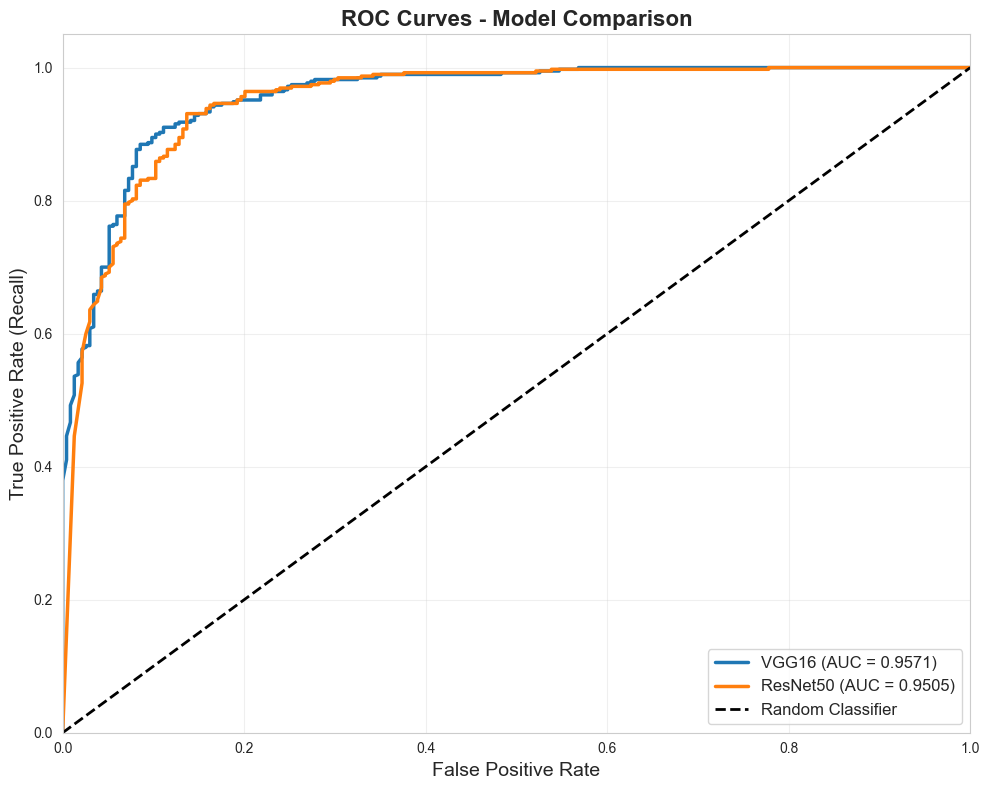

✓ VGG16 AUC: 0.9571
✓ ResNet50 AUC: 0.9505


In [99]:
# ROC Curves
print("\n📊 Generating ROC curves...")

fig, ax = plt.subplots(figsize=(10, 8))

# VGG16 ROC
fpr_vgg, tpr_vgg, _ = roc_curve(vgg_labels, vgg_probs)
roc_auc_vgg = auc(fpr_vgg, tpr_vgg)
ax.plot(fpr_vgg, tpr_vgg, linewidth=2.5, 
        label=f'VGG16 (AUC = {roc_auc_vgg:.4f})')

# ResNet50 ROC
fpr_resnet, tpr_resnet, _ = roc_curve(resnet_labels, resnet_probs)
roc_auc_resnet = auc(fpr_resnet, tpr_resnet)
ax.plot(fpr_resnet, tpr_resnet, linewidth=2.5, 
        label=f'ResNet50 (AUC = {roc_auc_resnet:.4f})')

# Random classifier
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=14)
ax.set_ylabel('True Positive Rate (Recall)', fontsize=14)
ax.set_title('ROC Curves - Model Comparison', fontsize=16, fontweight='bold')
ax.legend(loc="lower right", fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ VGG16 AUC: {roc_auc_vgg:.4f}")
print(f"✓ ResNet50 AUC: {roc_auc_resnet:.4f}")

### 6.3 Confusion Matrices
Visualizing true positives, false positives, true negatives, and false negatives.


📊 Generating confusion matrices...


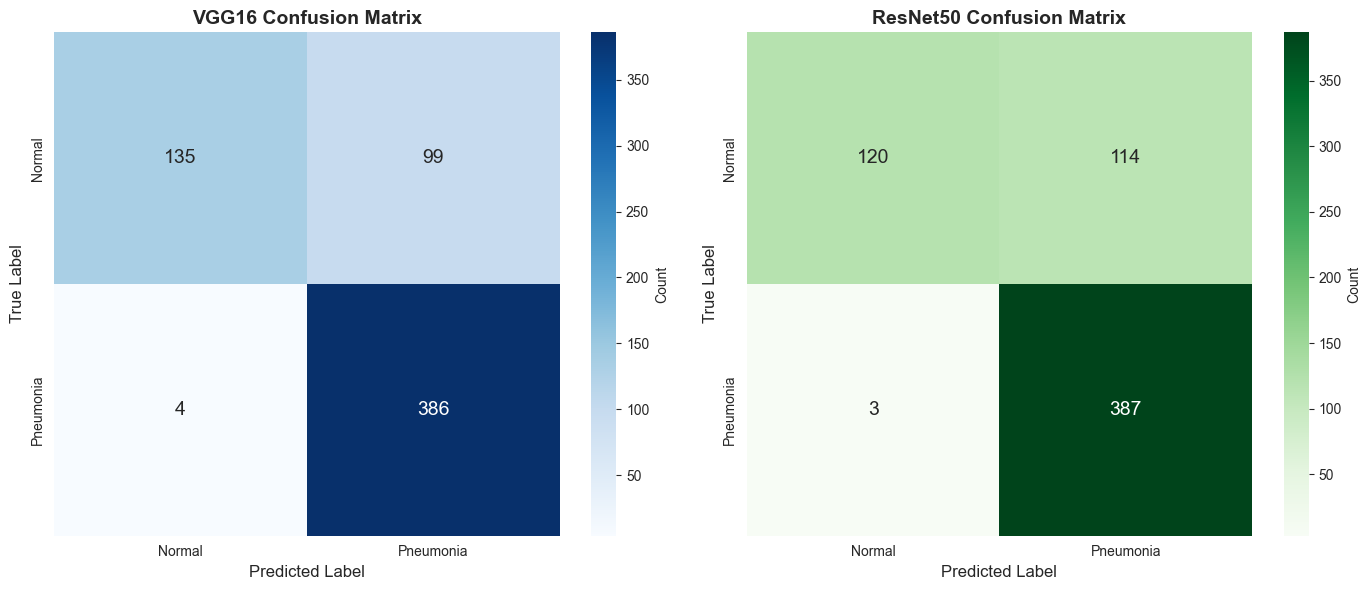

✓ Confusion matrices saved


In [100]:
# Confusion Matrices
print("\n📊 Generating confusion matrices...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# VGG16 Confusion Matrix
cm_vgg = confusion_matrix(vgg_labels, vgg_preds)
sns.heatmap(cm_vgg, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Count'}, ax=ax1, annot_kws={'size': 14})
ax1.set_ylabel('True Label', fontsize=12)
ax1.set_xlabel('Predicted Label', fontsize=12)
ax1.set_title('VGG16 Confusion Matrix', fontsize=14, fontweight='bold')

# ResNet50 Confusion Matrix
cm_resnet = confusion_matrix(resnet_labels, resnet_preds)
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Greens', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Count'}, ax=ax2, annot_kws={'size': 14})
ax2.set_ylabel('True Label', fontsize=12)
ax2.set_xlabel('Predicted Label', fontsize=12)
ax2.set_title('ResNet50 Confusion Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrices saved")

### 6.4 Comprehensive Visual Comparison
6-panel comparison showing all key metrics and visualizations.


📊 Creating comprehensive comparison...


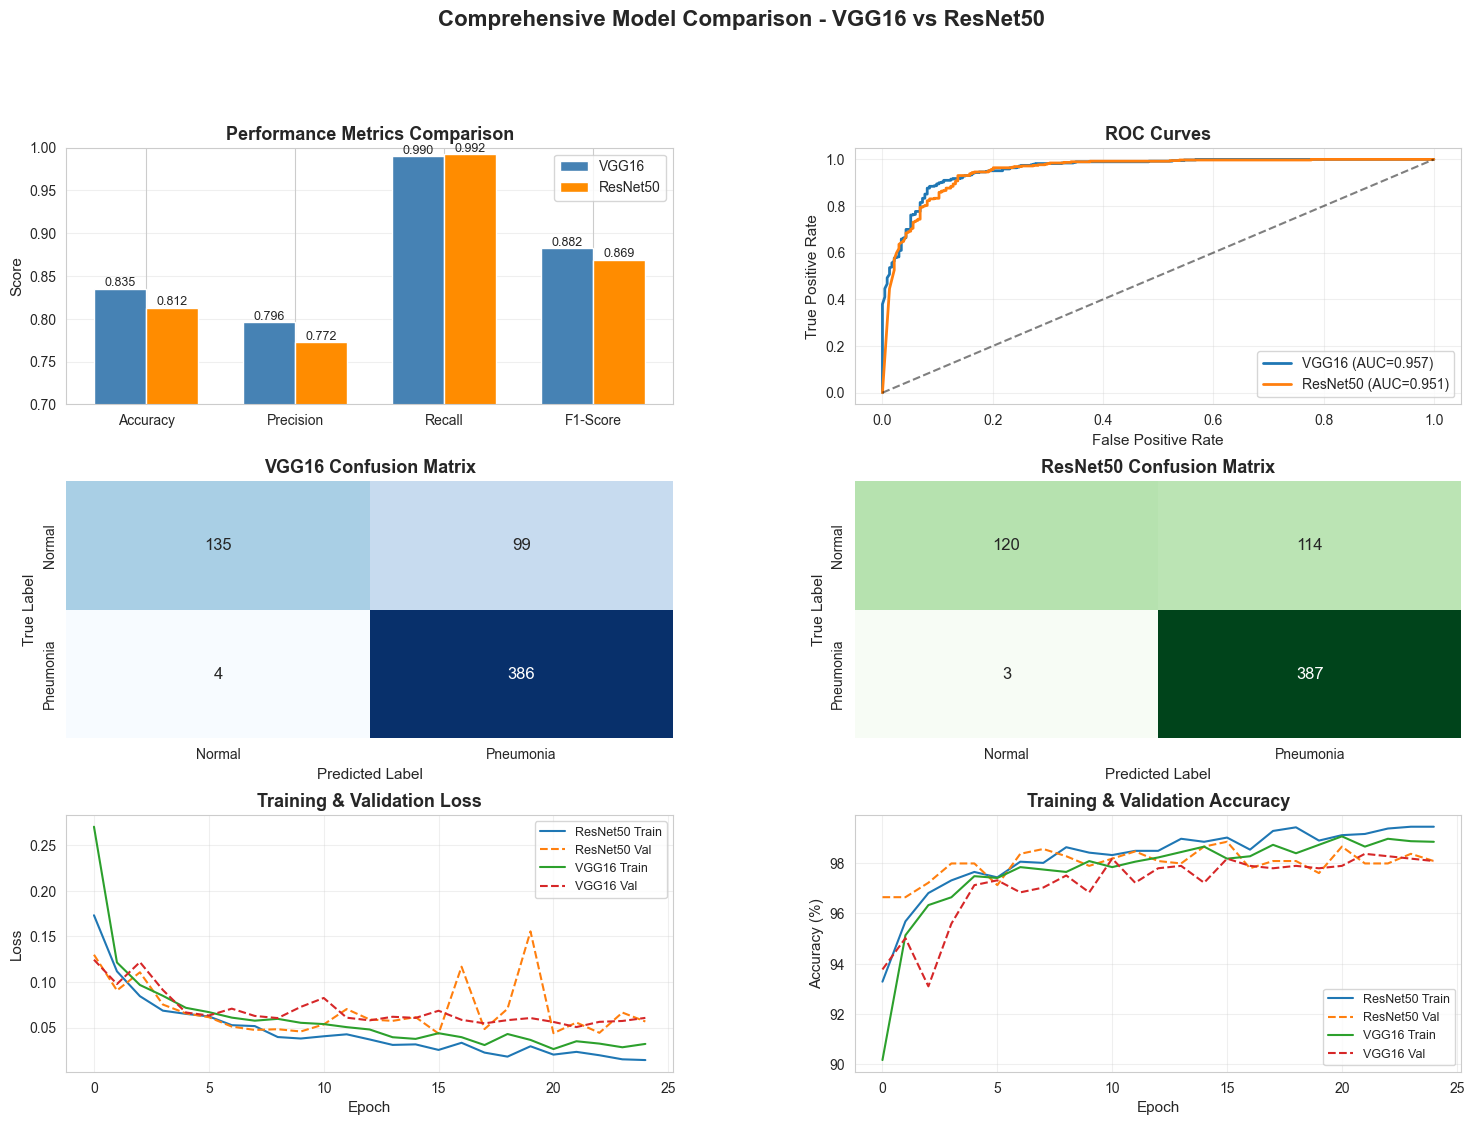

✓ Comprehensive comparison saved


In [ ]:
# Comprehensive 6-Panel Comparison
print("\n📊 Creating comprehensive comparison...")

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Metrics Bar Chart
ax1 = fig.add_subplot(gs[0, 0])
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
vgg_metrics = [vgg_acc, vgg_prec, vgg_rec, vgg_f1]
resnet_metrics = [resnet_acc, resnet_prec, resnet_rec, resnet_f1]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax1.bar(x - width/2, vgg_metrics, width, label='VGG16', color='steelblue')
bars2 = ax1.bar(x + width/2, resnet_metrics, width, label='ResNet50', color='darkorange')

ax1.set_ylabel('Score', fontsize=11)
ax1.set_title('Performance Metrics Comparison', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics, fontsize=10)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim([0.7, 1.0])

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 2. ROC Curves
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(fpr_vgg, tpr_vgg, linewidth=2, label=f'VGG16 (AUC={roc_auc_vgg:.3f})')
ax2.plot(fpr_resnet, tpr_resnet, linewidth=2, label=f'ResNet50 (AUC={roc_auc_resnet:.3f})')
ax2.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.5)
ax2.set_xlabel('False Positive Rate', fontsize=11)
ax2.set_ylabel('True Positive Rate', fontsize=11)
ax2.set_title('ROC Curves', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# 3. VGG16 Confusion Matrix
ax3 = fig.add_subplot(gs[1, 0])
sns.heatmap(cm_vgg, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            ax=ax3, cbar=False, annot_kws={'size': 12})
ax3.set_title('VGG16 Confusion Matrix', fontsize=13, fontweight='bold')
ax3.set_ylabel('True Label', fontsize=11)
ax3.set_xlabel('Predicted Label', fontsize=11)

# 4. ResNet50 Confusion Matrix
ax4 = fig.add_subplot(gs[1, 1])
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Greens',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            ax=ax4, cbar=False, annot_kws={'size': 12})
ax4.set_title('ResNet50 Confusion Matrix', fontsize=13, fontweight='bold')
ax4.set_ylabel('True Label', fontsize=11)
ax4.set_xlabel('Predicted Label', fontsize=11)

# 5. Training Loss
ax5 = fig.add_subplot(gs[2, 0])
ax5.plot(resnet_history['train_loss'], label='ResNet50 Train', linestyle='-')
ax5.plot(resnet_history['val_loss'], label='ResNet50 Val', linestyle='--')
ax5.plot(vgg_history['train_loss'], label='VGG16 Train', linestyle='-')
ax5.plot(vgg_history['val_loss'], label='VGG16 Val', linestyle='--')
ax5.set_xlabel('Epoch', fontsize=11)
ax5.set_ylabel('Loss', fontsize=11)
ax5.set_title('Training & Validation Loss', fontsize=13, fontweight='bold')
ax5.legend(fontsize=9)
ax5.grid(True, alpha=0.3)

# 6. Training Accuracy
ax6 = fig.add_subplot(gs[2, 1])
ax6.plot(resnet_history['train_acc'], label='ResNet50 Train', linestyle='-')
ax6.plot(resnet_history['val_acc'], label='ResNet50 Val', linestyle='--')
ax6.plot(vgg_history['train_acc'], label='VGG16 Train', linestyle='-')
ax6.plot(vgg_history['val_acc'], label='VGG16 Val', linestyle='--')
ax6.set_xlabel('Epoch', fontsize=11)
ax6.set_ylabel('Accuracy (%)', fontsize=11)
ax6.set_title('Training & Validation Accuracy', fontsize=13, fontweight='bold')
ax6.legend(fontsize=9)
ax6.grid(True, alpha=0.3)

plt.suptitle('Comprehensive Model Comparison - VGG16 vs ResNet50', 
             fontsize=16, fontweight='bold', y=0.995)
plt.savefig(RESULTS_DIR / 'comprehensive_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Comprehensive comparison saved")

### 6.5 Error Analysis Breakdown
Detailed analysis of false positives and false negatives.


📊 Creating error analysis...

VGG16 Error Breakdown:
  Total Normal: 234
    Correctly identified: 135 (57.69%)
    False Positives (Normal→Pneumonia): 99 (42.31%)

  Total Pneumonia: 390
    Correctly identified: 386 (98.97%)
    False Negatives (Pneumonia→Normal): 4 (1.03%)

  ⚠️  CRITICAL: 4 pneumonia cases missed!

ResNet50 Error Breakdown:
  Total Normal: 234
    Correctly identified: 120 (51.28%)
    False Positives (Normal→Pneumonia): 114 (48.72%)

  Total Pneumonia: 390
    Correctly identified: 387 (99.23%)
    False Negatives (Pneumonia→Normal): 3 (0.77%)

  ⚠️  CRITICAL: 3 pneumonia cases missed!


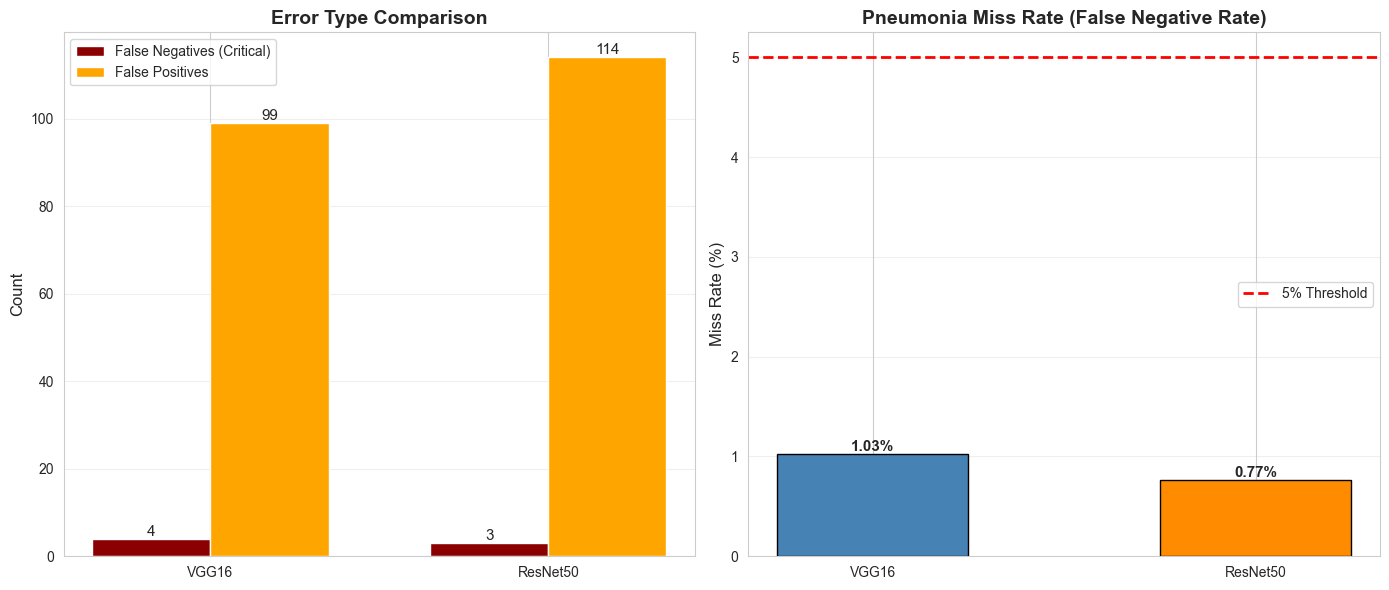


✓ Error analysis complete


In [102]:
# Error Analysis
print("\n📊 Creating error analysis...")

def analyze_errors(labels, preds, model_name):
    """Analyze FP and FN for a model"""
    cm = confusion_matrix(labels, preds)
    
    # Extract values
    tn, fp, fn, tp = cm.ravel()
    
    total_normal = tn + fp
    total_pneumonia = fn + tp
    
    print(f"\n{model_name} Error Breakdown:")
    print(f"  Total Normal: {total_normal}")
    print(f"    Correctly identified: {tn} ({100*tn/total_normal:.2f}%)")
    print(f"    False Positives (Normal→Pneumonia): {fp} ({100*fp/total_normal:.2f}%)")
    print(f"\n  Total Pneumonia: {total_pneumonia}")
    print(f"    Correctly identified: {tp} ({100*tp/total_pneumonia:.2f}%)")
    print(f"    False Negatives (Pneumonia→Normal): {fn} ({100*fn/total_pneumonia:.2f}%)")
    print(f"\n  ⚠️  CRITICAL: {fn} pneumonia cases missed!")
    
    return {'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp}

vgg_errors = analyze_errors(vgg_labels, vgg_preds, 'VGG16')
resnet_errors = analyze_errors(resnet_labels, resnet_preds, 'ResNet50')

# Visualize Error Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

models = ['VGG16', 'ResNet50']
fn_counts = [vgg_errors['FN'], resnet_errors['FN']]
fp_counts = [vgg_errors['FP'], resnet_errors['FP']]

x = np.arange(len(models))
width = 0.35

# Error counts
ax = axes[0]
bars1 = ax.bar(x - width/2, fn_counts, width, label='False Negatives (Critical)', color='darkred')
bars2 = ax.bar(x + width/2, fp_counts, width, label='False Positives', color='orange')
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Error Type Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontsize=11)

# Miss rates
ax = axes[1]
pneumonia_total = vgg_errors['FN'] + vgg_errors['TP']  # Same for both models
vgg_miss_rate = 100 * vgg_errors['FN'] / pneumonia_total
resnet_miss_rate = 100 * resnet_errors['FN'] / pneumonia_total

bars = ax.bar(models, [vgg_miss_rate, resnet_miss_rate], 
              color=['steelblue', 'darkorange'], edgecolor='black', width=0.5)
ax.set_ylabel('Miss Rate (%)', fontsize=12)
ax.set_title('Pneumonia Miss Rate (False Negative Rate)', fontsize=14, fontweight='bold')
ax.axhline(y=5, color='red', linestyle='--', linewidth=2, label='5% Threshold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Error analysis complete")